Terminal

In [ ]:
!pip install colab-xterm
%load_ext colabxterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 1.2 MB/s eta 0:00:00


Kopiuj zbiór danych:


curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

unzip -q kagglecatsanddogs_5340.zip

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Usun uszkodzone pliki

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


Przygotowanie danych do uczenia sieci

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Drobne modyfikacje obrazów w celu zwiększenia puli obrazów dostępnych do uczenia sieci

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

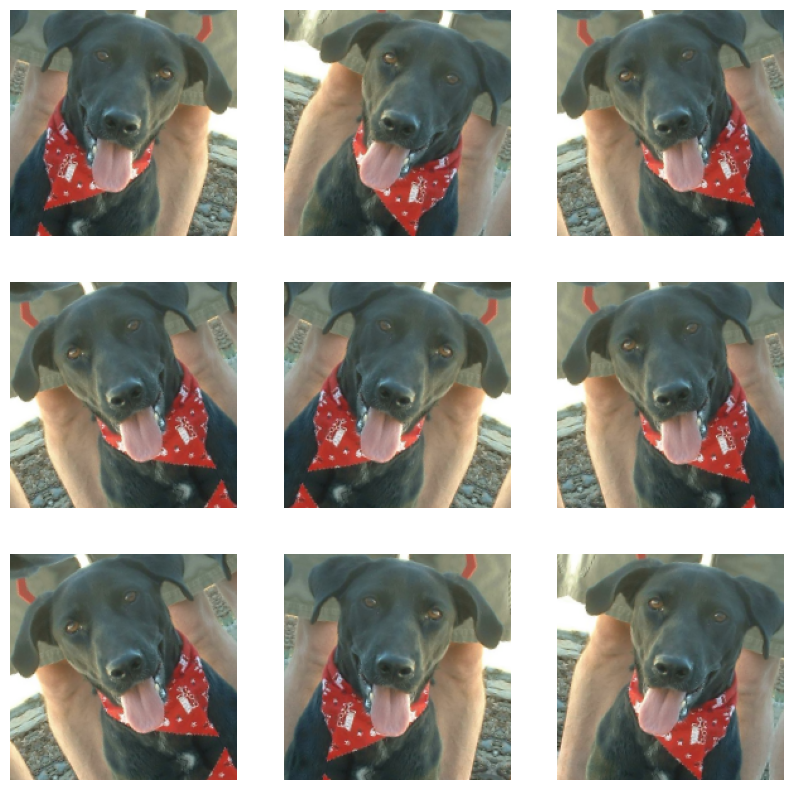

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

zmiana palety kolorów z rgb (0,255) na (0,1)

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Budowa modelu sieci

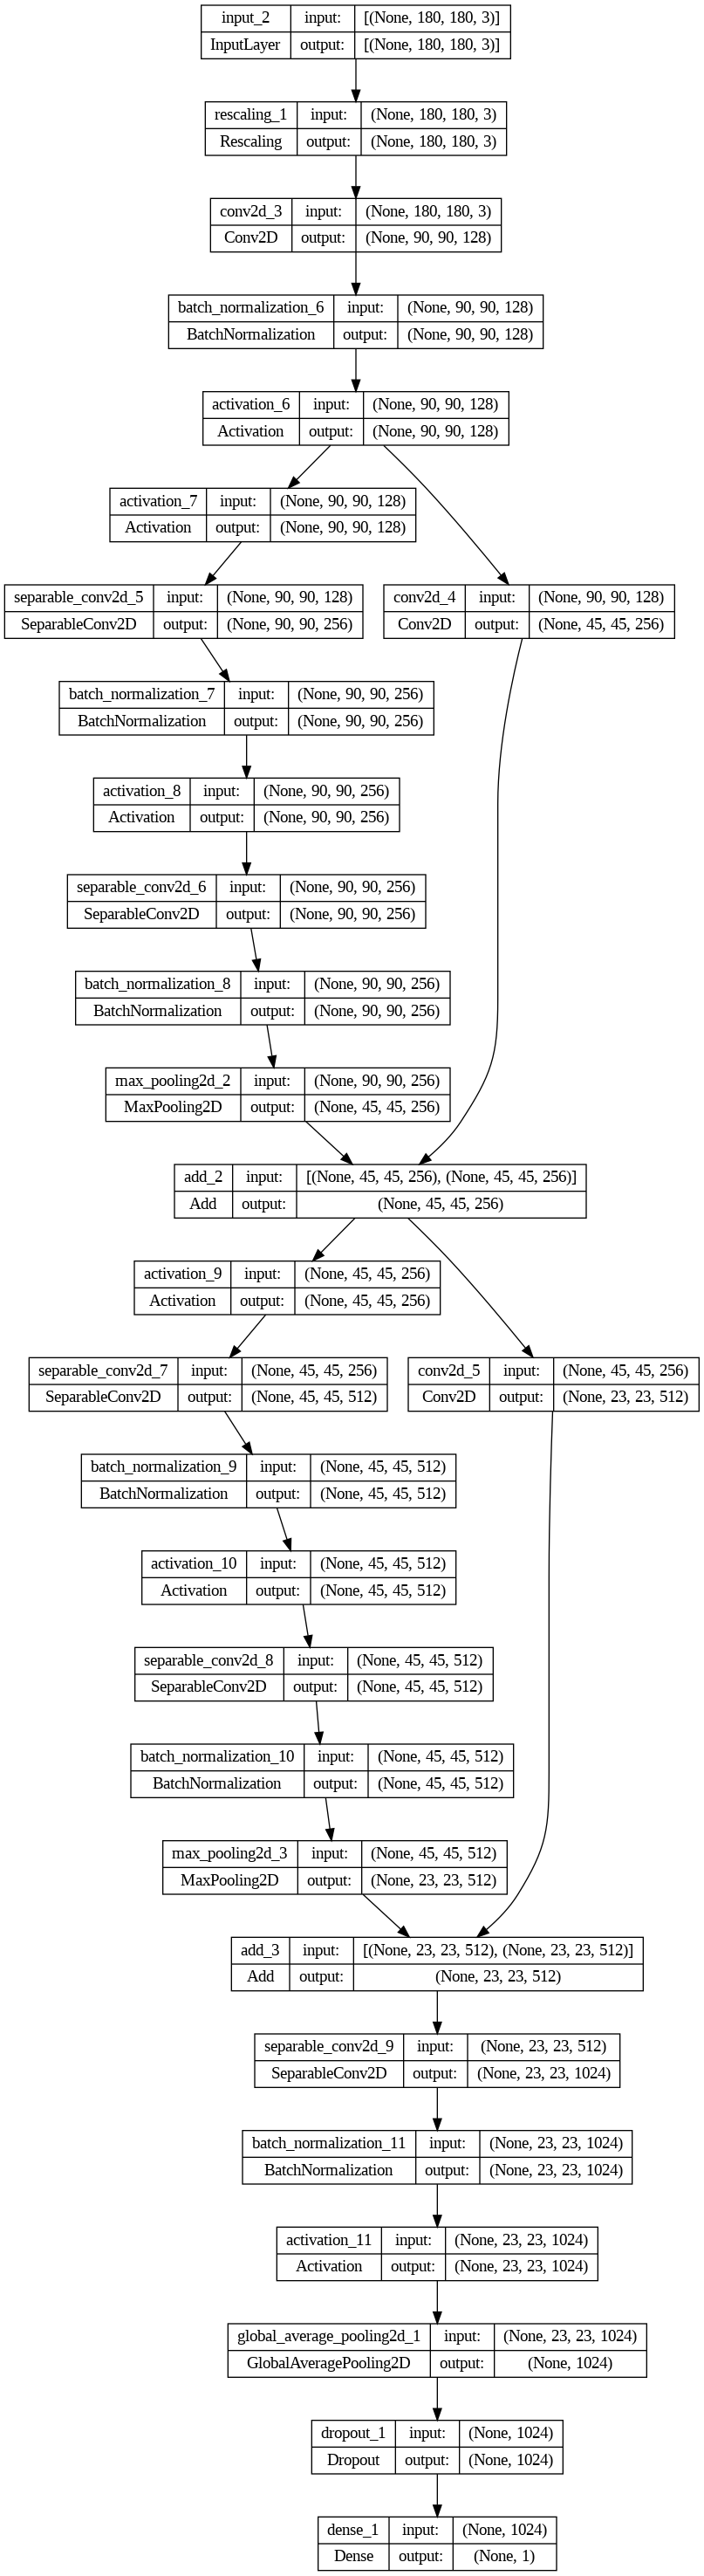

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Uczenie sieci:

In [ ]:
  epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 228s 1s/step - loss: 0.6170 - accuracy: 0.6599 - val_loss: 0.7206 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 192s 1s/step - loss: 0.5159 - accuracy: 0.7486 - val_loss: 1.1760 - val_accuracy: 0.4957
Epoch 3/25
147/147 [==============================] - 194s 1s/step - loss: 0.4326 - accuracy: 0.8006 - val_loss: 2.0915 - val_accuracy: 0.4957
Epoch 4/25
147/147 [==============================] - 202s 1s/step - loss: 0.3832 - accuracy: 0.8296 - val_loss: 0.4125 - val_accuracy: 0.8189
Epoch 5/25
147/147 [==============================] - 202s 1s/step - loss: 0.3468 - accuracy: 0.8494 - val_loss: 0.3444 - val_accuracy: 0.8539
Epoch 6/25
147/147 [==============================] - 203s 1s/step - loss: 0.3184 - accuracy: 0.8654 - val_loss: 0.4727 - val_accuracy: 0.8052
Epoch 7/25
147/147 [==============================] - 189s 1s/step - loss: 0.2892 - accuracy: 0.8786 - val_loss: 0.3407 - val_accuracy: 0.8610

Sprawdzenie kożystając z sieci

1/1 [==============================] - 0s 37ms/step
This image is 0.01% cat and 99.99% dog.


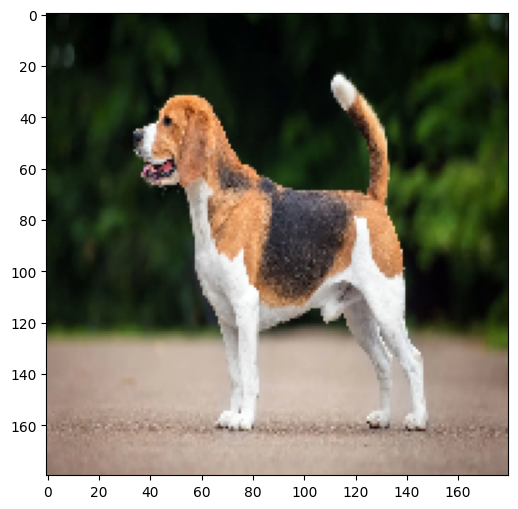

In [ ]:
img = keras.utils.load_img(
    "PetImages/d.png", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

Zapisz model

In [ ]:
model.save("model no dropout size.keras")

Załąduj mode:

In [ ]:
image_size = (180, 180)
batch_size = 128
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/modele/model no dropout size.keras")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Testowanie modelu

In [ ]:
from os import listdir
from os.path import isfile, join

cats = [f for f in listdir("/content/drive/MyDrive/modele/test_set/cats") if isfile(join("/content/drive/MyDrive/modele/test_set/cats", f))]
dogs = [f for f in listdir("/content/drive/MyDrive/modele/test_set/dogs") if isfile(join("/content/drive/MyDrive/modele/test_set/dogs", f))]

tests_count = 999

cat_sum = 0
dog_sum = 0

for x in range(0, tests_count):
    path = "/content/drive/MyDrive/modele/test_set/cats/" + cats[x]
    img = keras.utils.load_img(
    path, target_size=image_size
    )

    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)
    score = float(predictions[0])
    sc = 100 * (1 - score)
    if sc > 75.0:
      cat_sum += sc

for x in range(0, tests_count):
    path = "/content/drive/MyDrive/modele/test_set/dogs/" + dogs[x]
    img = keras.utils.load_img(
    path, target_size=image_size
    )

    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)
    score = float(predictions[0])
    sc = 100 * score
    if sc > 75.0:
      dog_sum += sc

cat_ac = cat_sum / tests_count
print("Rozpoznawanie kotów: ")
print(cat_ac)
print("% ")

dog_ac = dog_sum / tests_count
print("Rozpoznawanie psów: ")
print(dog_ac)
print("%")

1/1 [==============================] - 0s 22ms/step
Rozpoznawanie kotów: 
91.40784617669789
% 
Rozpoznawanie psów: 
95.12462787800007
%
